In [1]:
# Import necessary libraries for data handling
import pandas as pd
import numpy as np
import re
import string

# Load both datasets containing true and fake news articles
true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

# Add labels to datasets: 0 = True news, 1 = Fake news
true_df['label'] = 0
fake_df['label'] = 1

# Merge both datasets into one dataframe
df = pd.concat([true_df, fake_df], ignore_index=True)

# Shuffle rows randomly to avoid any bias
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Remove columns that are not essential for text classification
df.drop(['date', 'subject'], axis=1, inplace=True)

# Display first few rows to verify combined data
print(df.head())

# Function to clean textual data (remove punctuation, symbols, numbers, etc.)
def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text inside brackets
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)  # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Combine title and text, then apply the cleaning function
df['clean_text'] = df['title'] + " " + df['text']
df['clean_text'] = df['clean_text'].apply(clean_text)

# Check results of text cleaning
print(df[['clean_text', 'label']].head())

                                               title  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                text  label  
0  Donald Trump s White House is in chaos, and th...      1  
1  Now that Donald Trump is the presumptive GOP n...      1  
2  Mike Pence is a huge homophobe. He supports ex...      1  
3  SAN FRANCISCO (Reuters) - California Attorney ...      0  
4  Twisted reasoning is all that comes from Pelos...      1  
                                          clean_text  label
0  breaking gop chairman grassley has had enough ...      1
1  failed gop candidates remembered in hilarious ...      1
2  mike pence’s new dc neighbors are hilariously ...      1
3  california ag pledges to defend birth control ..

In [2]:
# Import library to convert text data into numerical features
from sklearn.feature_extraction.text import TfidfVectorizer

# Use TF-IDF to transform text data into numerical data (for machine learning)
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Generate numeric features from cleaned text
X = tfidf.fit_transform(df['clean_text']).toarray()

# Store the corresponding labels
y = df['label'].values

# Display shape (rows, columns) of the numerical dataset
print(f'TF-IDF feature vector shape: {X.shape}')


TF-IDF feature vector shape: (44898, 5000)


In [5]:
# Import libraries to split dataset and build classification models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# MODEL 1: Logistic Regression (simple, fast model)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)  # Train the logistic regression model
y_pred_lr = log_reg.predict(X_test)  # Make predictions on the test set

# Display performance of Logistic Regression model
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# MODEL 2: Random Forest (more complex, usually powerful)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)  # Train the random forest model
y_pred_rf = rf.predict(X_test)  # Make predictions on the test set

# Display performance of Random Forest model
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4311
           1       0.99      0.99      0.99      4669

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion Matrix:
 [[4271   40]
 [  69 4600]]
Accuracy: 0.9878619153674832

Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4311
           1       1.00      1.00      1.00      4669

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

Confusion Matrix:
 [[4303    8]
 [  20 4649]]
Accuracy: 0.9968819599109131


In [7]:
# Import joblib to save models and vectorizer
import joblib

# Save the best model (assume Logistic Regression was better; change if needed)
joblib.dump(log_reg, 'fake_news_detector_model.pkl')

# Save the TF-IDF vectorizer as well (necessary for new predictions)
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [9]:
from sklearn.model_selection import cross_val_score

# Evaluate Logistic Regression model using 5-fold cross-validation
cross_val_scores = cross_val_score(log_reg, X, y, cv=5, scoring='accuracy', n_jobs=-1)

# Output cross-validation results
print(f"Cross-validation accuracies: {cross_val_scores}")
print(f"Mean cross-validation accuracy: {cross_val_scores.mean():.4f}")

Cross-validation accuracies: [0.98730512 0.98775056 0.98652561 0.98585589 0.98808331]
Mean cross-validation accuracy: 0.9871


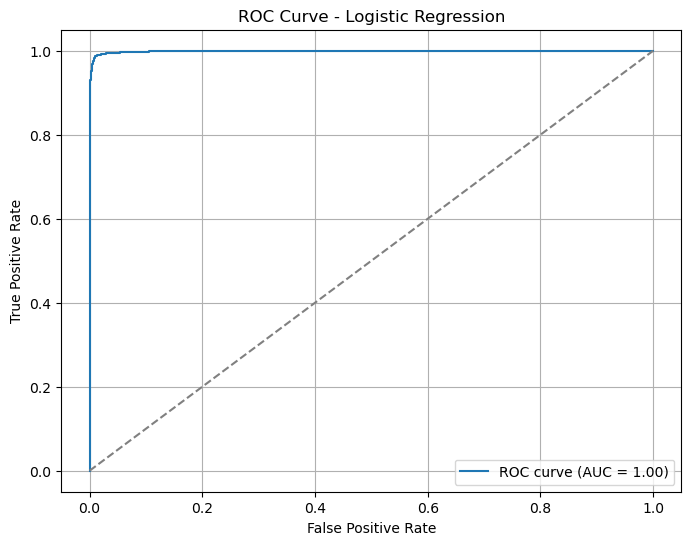

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate probabilities for ROC curve
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
roc_auc = roc_auc_score(y_test, y_prob_lr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.grid()
plt.show()

In [13]:
# Load saved model and vectorizer (just to demonstrate reuse)
import joblib
model = joblib.load('fake_news_detector_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# New (unseen) examples to classify
examples = [
    "Government passes new healthcare reform bill with bipartisan support.",
    "Donald Trump secretly negotiating with aliens according to leaked reports!"
]

# Preprocess and predict
example_features = vectorizer.transform(examples)
predictions = model.predict(example_features)

# Display predictions
for text, pred in zip(examples, predictions):
    print(f'Article: "{text}"')
    print('Prediction:', 'Fake News' if pred == 1 else 'Real News', '\n')

Article: "Government passes new healthcare reform bill with bipartisan support."
Prediction: Real News 

Article: "Donald Trump secretly negotiating with aliens according to leaked reports!"
Prediction: Fake News 



In [15]:
# Extracting top features indicative of fake/real news
feature_names = vectorizer.get_feature_names_out()
coef = log_reg.coef_[0]

# Top 10 features associated with Fake and True news
top_fake_words = sorted(zip(coef, feature_names), reverse=True)[:10]
top_true_words = sorted(zip(coef, feature_names))[:10]

print("Top 10 words strongly indicating Fake news:")
for coef, word in top_fake_words:
    print(f"{word}: {coef:.3f}")

print("\nTop 10 words strongly indicating Real news:")
for coef, word in top_true_words:
    print(f"{word}: {coef:.3f}")

Top 10 words strongly indicating Fake news:
just: 6.927
image: 6.315
gop: 5.980
hillary: 5.482
breaking: 4.385
mr: 4.288
video: 4.268
images: 4.256
wire: 4.118
watch: 4.059

Top 10 words strongly indicating Real news:
reuters: -27.656
said: -18.351
washington: -6.289
wednesday: -5.648
tuesday: -5.167
thursday: -5.016
friday: -4.757
republican: -4.533
nov: -4.424
monday: -3.991
